In [52]:
import numpy as np
import plotly.graph_objs as go
import matplotlib.pyplot as plt

In [53]:
pred_full = np.load('pred_full.npy') # load

In [54]:
def hysteresis_bufferless(time_series: np.ndarray, low_threshold: float, high_threshold: float) -> tuple[list[int], list[int]]:
    # Initial state based on the first value
    above_high = time_series[0] > high_threshold
    below_low = time_series[0] < low_threshold

    transition_to_high = []
    transition_to_low = []

    for i, value in enumerate(time_series):
        if above_high and value < low_threshold:
            # Transition from above high to below low
            transition_to_low.append(i)
            above_high = False
            below_low = True
        elif below_low and value > high_threshold:
            # Transition from below low to above high
            transition_to_high.append(i)
            below_low = False
            above_high = True

    return transition_to_low, transition_to_high


def hysteresis(time_series: np.ndarray, low_threshold: float, high_threshold: float, buffer: int = 15) -> tuple[list[int], list[int]]:
    # Initial state based on the first value
    above_high = time_series[0] > high_threshold
    below_low = time_series[0] < low_threshold

    transition_to_high = []
    transition_to_low = []

    potential_transition_start = None

    for i, value in enumerate(time_series):
        if above_high and value < low_threshold:
            # Potential transition from above high to below low
            if potential_transition_start is None:
                potential_transition_start = i
            above_high = False
            below_low = True
        elif below_low and value > high_threshold:
            # Potential transition from below low to above high
            if potential_transition_start is None:
                potential_transition_start = i
            below_low = False
            above_high = True

        # Check if the potential transition has lasted long enough
        if potential_transition_start is not None:
            if i - potential_transition_start >= buffer:
                # Confirm the transition
                if below_low:
                    transition_to_high.append(potential_transition_start)
                else:
                    transition_to_low.append(potential_transition_start)
                potential_transition_start = None

    return transition_to_low, transition_to_high


def plotly_line_charts(pixel_counts, save=False):
    """
    Create an interactive line chart with one or two lines.

    Args:
        pixel_counts (numpy array): First line data (e.g., probability of contact).
        save (bool or str): False, or name of file to save to

    Returns:
        None
    """
    # Create a Plotly figure
    fig = go.Figure()

    # Add a trace for the first line (e.g., blue pixel counts)
    fig.add_trace(go.Scatter(x=np.arange(len(pixel_counts))/29.97,
                             y=pixel_counts,
                             mode='lines',
                             name='Probability of Contact'))


    # Customize the layout
    fig.update_layout(
        xaxis_title="Time (s)",
        yaxis_title="Value",
        title=f"Probability of Contact"
    )

    # Enable zooming and panning
    fig.update_xaxes(type='linear')
    fig.update_yaxes(type='linear')

    if save:
        fig.write_html(save)

    # Display the interactive plot
    fig.show()


def plotly_line_charts_with_transitions(pixel_counts: np.ndarray, transition_indices: list[tuple], fps: float = 29.97, title: str = 'Contact Duration Segmentation', save=False):
    """
    Create an interactive line chart with shaded regions indicating transitions.

    Args:
        pixel_counts (numpy array): Line data (e.g., probability of contact).
        transition_indices (list of tuples): Pairs of indices indicating the start and end of transitions.
        fps (float): Frames per second for converting indices to time.
        title (str): Title of the figure.
        save (bool or str): False, or name of file to save to.

    Returns:
        None
    """
    # Create a Plotly figure
    fig = go.Figure()

    # Add a trace for the line
    fig.add_trace(go.Scatter(x=np.arange(len(pixel_counts)) / fps,
                             y=pixel_counts,
                             mode='lines',
                             name=""))

    # Add shaded regions for each transition period
    
    for start_idx, end_idx in transition_indices:
        print(start_idx, end_idx)
        start_time = start_idx / fps
        end_time = end_idx / fps
        duration = (end_idx - start_idx) / fps

        # Add a rectangle shape to represent the shaded region
        fig.add_shape(
            type="rect",
            x0=start_time,
            x1=end_time,
            y0=0,
            y1=max(pixel_counts),  # Adjust according to the range of your data
            fillcolor="LightSkyBlue",
            opacity=0.5,
            layer="below",
            line_width=0
        )

        # Add hover text for the shaded region
        fig.add_trace(go.Scatter(
            x=[(start_time + end_time) / 2],
            y=[max(pixel_counts) / 2],  # Adjust according to the range of your data
            text=[f"{duration:.1f} s"],
            mode="text",
            showlegend=False
        ))

    # Customize the layout
    fig.update_layout(
        xaxis_title="Time (s)",
        yaxis_title="Contact Probability",
        title=title
    )

    # Enable zooming and panning
    fig.update_xaxes(type='linear')
    fig.update_yaxes(type='linear')

    if save:
        fig.write_html(save)

    fig.show()
    

def plotly_changepoint(pixel_counts, changepoints: list[int] = None, fps: float = 29.97, save: bool = False):
    """
    Create an interactive line chart with one or two lines.

    Args:
        pixel_counts (numpy array): First line data (e.g., probability of contact).
        changepoints (list of int): List of indices to add black dotted vertical lines.
        fps (float): Fps for x-axis
        save (bool or str): False, or name of file to save to.

    Returns:
        None
    """
    # Create a Plotly figure
    fig = go.Figure()

    # Add a trace for the first line (e.g., blue pixel counts)
    fig.add_trace(go.Scatter(x=np.arange(len(pixel_counts))/fps,
                             y=pixel_counts,
                             mode='lines',
                             name='Probability of Contact'))

    # Add vertical lines at changepoints
    if changepoints is not None:
        for index in changepoints:
            fig.add_shape(
                go.layout.Shape(
                    type="line",
                    x0=index/fps,
                    x1=index/fps,
                    y0=0,
                    y1=1,
                    line=dict(color="black", dash="dot")
                )
            )

    # Customize the layout
    fig.update_layout(
        xaxis_title="Time (s)",
        yaxis_title="Value",
        title=f"Probability of Contact"
    )

    # Enable zooming and panning
    fig.update_xaxes(type='linear')
    fig.update_yaxes(type='linear')

    if save:
        fig.write_html(save)

    # Display the interactive plot
    fig.show()
    
    
def hysteresis(time_series: np.ndarray, low_threshold: float, high_threshold: float, buffer: int):
    above_high = time_series[0] > high_threshold
    below_low = time_series[0] < low_threshold

    # Tracking the start and end of the transitions
    transition_starts = []
    transitions = []

    for i, value in enumerate(time_series):
        if above_high and value < low_threshold:
            if not transition_starts:  # If there's no start yet, this is a new transition
                transition_starts.append(i)
            above_high = False
            below_low = True
        elif below_low and value > high_threshold:
            if not transition_starts:  # New transition
                transition_starts.append(i)
            below_low = False
            above_high = True

        # Check for the end of a transition
        if transition_starts and i - transition_starts[-1] >= buffer:
            transitions.append((transition_starts.pop(), i))  # Add the start and end of the transition

    # Handle any ongoing transition at the end if necessary
    if transition_starts:
        transitions.append((transition_starts.pop(), len(time_series) - 1))

    # Separate the transitions into high and low based on the value at the start of the transition
    transition_to_low = []
    transition_to_high = []
    for start, end in transitions:
        if time_series[start] > high_threshold:
            transition_to_high.append((start, end))
        else:
            transition_to_low.append((start, end))

    return transition_to_low, transition_to_high


In [55]:
to_low, to_high = hysteresis(pred_full, 0.4, 0.7, buffer=15)
print(len(to_low), len(to_high))

47 48


In [56]:
plotly_line_charts_with_transitions(pred_full, zip(to_high, to_low))

(44, 59) (496, 511)


TypeError: unsupported operand type(s) for /: 'tuple' and 'float'

In [57]:
int(0.8*len(pred_full))

11469

In [58]:
plotly_line_charts(pred_full[13200:])

# TRYING WITH RUPTURES PACKAGE

## binary segmentation

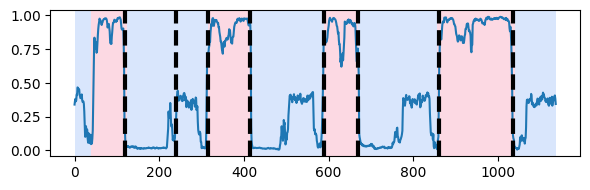

In [59]:
import ruptures as rpt


signal = pred_full[13200:]

model = "l2"  # "l1", "rbf", "linear", "normal", "ar"
algo = rpt.Binseg(model=model).fit(signal)
my_bkps = algo.predict(n_bkps=8)

true_bkps = [40, 125, 315, 415, 590, 670, 857, 1040, len(signal)] # eyeballing it

# fig, ax = plt.subplots(2, 2)
# show results
fig_current, ax_current = rpt.show.display(signal, true_bkps, my_bkps, figsize=(6, 2))
plt.show()

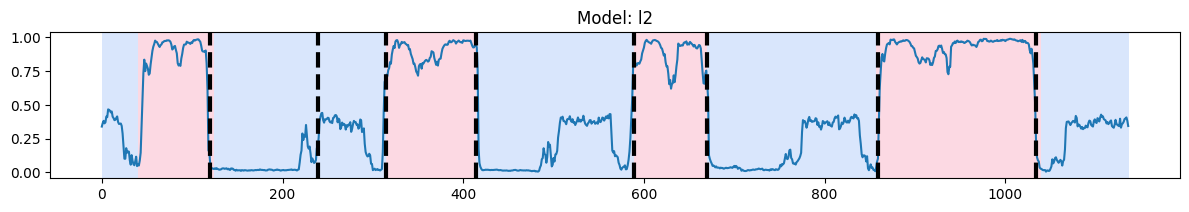

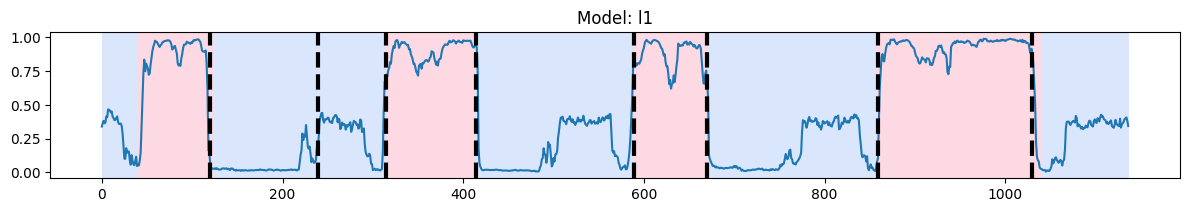

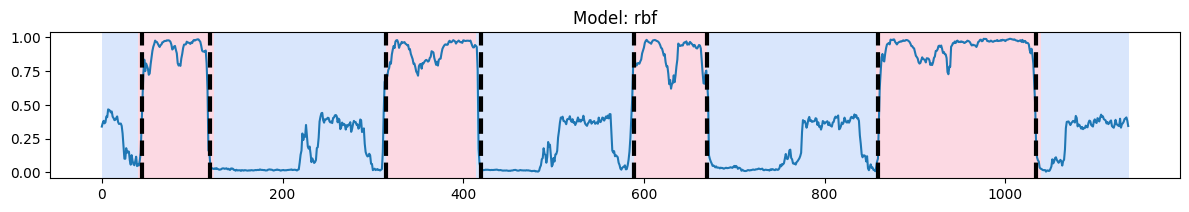

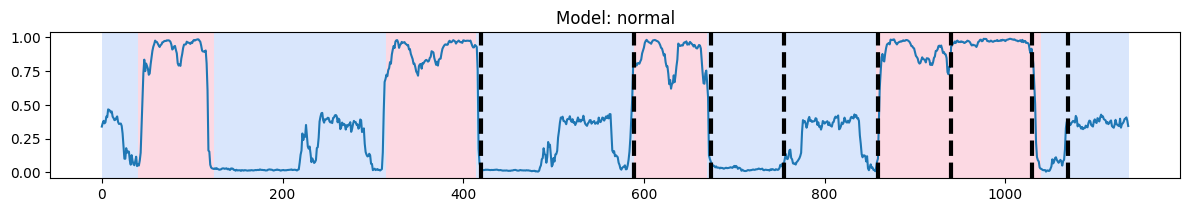

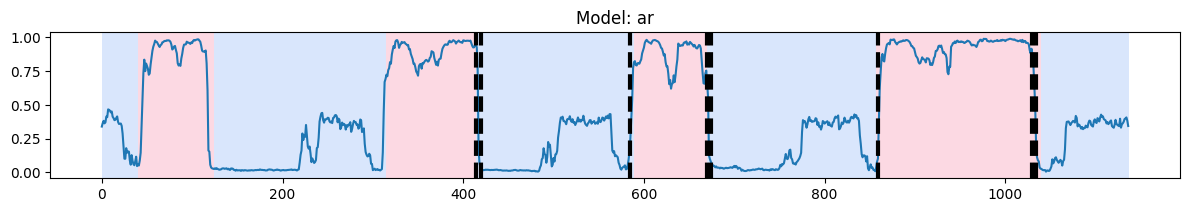

In [60]:
cost_fns = ["l2", "l1", "rbf", "normal", "ar"] # , "linear" requires more dimensions. gives error currently

for i, cost_fn in enumerate(cost_fns):
    # print(f"{i}: model {model}")
    algo = rpt.Binseg(model=cost_fn).fit(signal)
    my_bkps = algo.predict(n_bkps=8)

    # Plot the results in the corresponding subplot
    fig_current, ax_current = rpt.show.display(signal, true_bkps, my_bkps, figsize=(12, 2))
    plt.title(f"Model: {cost_fn}")

plt.show()

## PELT doesn't know how many changepoints, needs pen hyperparam

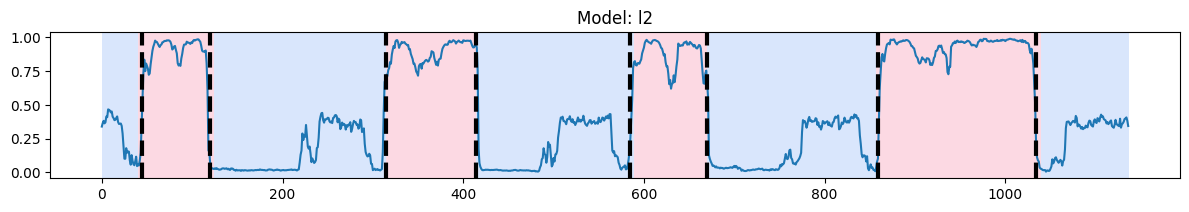

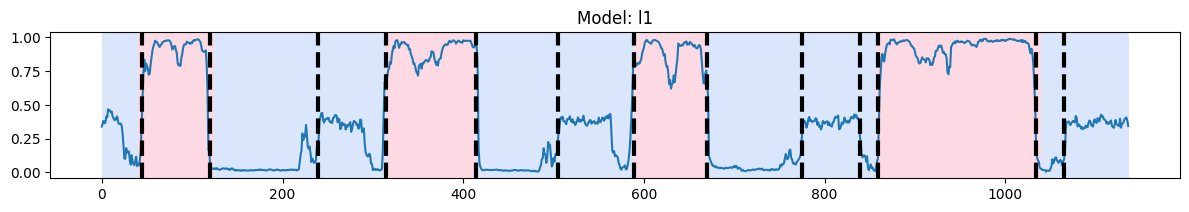

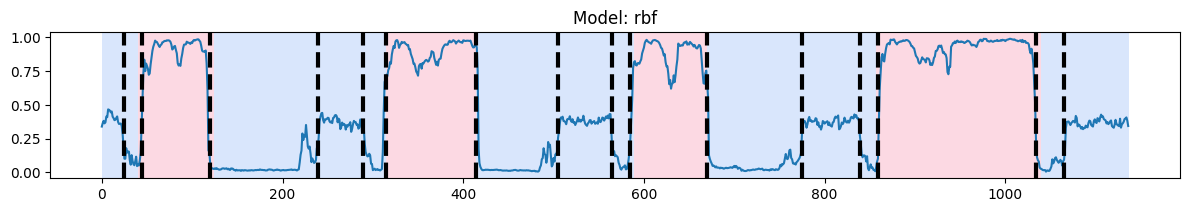

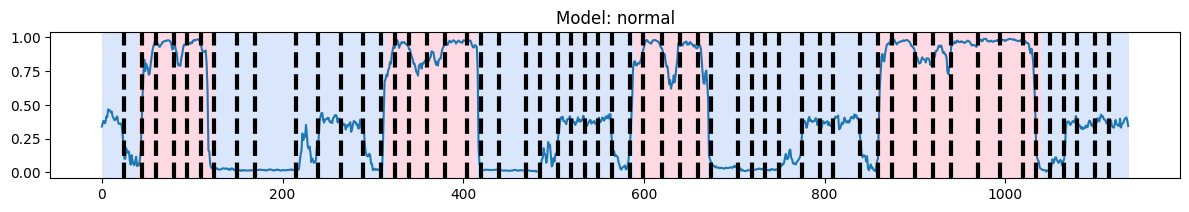

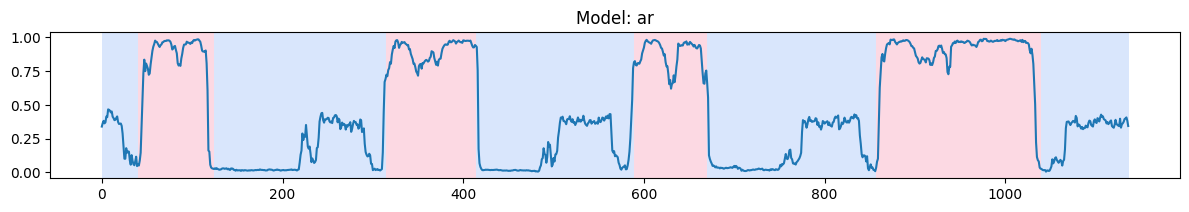

In [61]:
cost_fns = ["l2", "l1", "rbf", "normal", "ar"] # , "linear" requires more dimensions. gives error currently

for i, cost_fn in enumerate(cost_fns):
    # print(f"{i}: model {model}")
    algo = rpt.Pelt(model=cost_fn, min_size=15).fit(signal)
    my_bkps = algo.predict(pen=5)

    # Plot the results in the corresponding subplot
    fig_current, ax_current = rpt.show.display(signal, true_bkps, my_bkps, figsize=(12, 2))
    plt.title(f"Model: {cost_fn}")

plt.show()

In [62]:
algo = rpt.Pelt(model="l2", min_size=15).fit(pred_full)
my_bkps = algo.predict(pen=5)
# print(my_bkps)
plotly_changepoint(pred_full, my_bkps)

In [63]:
print(len(my_bkps)/2)

47.0


In [64]:
algo = rpt.Pelt(model="l2", min_size=15).fit(pred_full)
my_bkps = algo.predict(pen=10)

plotly_changepoint(pred_full, my_bkps)

# print(my_bkps)

In [65]:
print(len(my_bkps)/2)

46.5


# overlay

In [86]:
import cv2

def overlay_changepoints(video_path: str, changepoints: np.ndarray, output_path: str, frame_rate: float = 29.97) -> None:
    """
    Overlay a square with alpha 0.8 in alternating red and green colors based on when the participant is predicted to be holding the object

    Args:
        video_path (str): Path to the input video file.
        changepoints (np.ndarray): Numpy array of integers representing changepoint frames.
        output_path (str): Path to save the output video file.
        frame_rate (float, optional): Frame rate of the output video. Default is 29.97 fps.

    Returns:
        None
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Unable to open video at {video_path}")
        return

    ret, frame = cap.read()
    height, width, _ = frame.shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, frame_rate, (width, height))

    idx = 0
    is_green = False

    height, width, _ = frame.shape
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # for progress bar
    with tqdm(total=total_frames) as progress_bar_tqdm:
        while ret:
            if idx in changepoints:
                is_green = not is_green
            
            # Determine square color based on is_green
            square_color = (0, 255, 0) if is_green else (0, 0, 255)  # Green or red (BGR format)
    
            # Create a square with alpha 0.8
            overlay = frame.copy()
            
            square_size = int(0.15 * width)
            x_pos = width - square_size - int(0.1 * width)
            y_pos = height - square_size - int(0.1 * height)
            alpha = 0.7
            cv2.rectangle(overlay, (x_pos, y_pos), (x_pos + square_size, y_pos + square_size), square_color, -1)  # -1 fills the rectangle
            cv2.addWeighted(overlay, alpha, frame, 1 - alpha, 0, frame)  # Apply alpha blending
            
            out.write(frame)
            idx += 1
            
            ret, frame = cap.read()
            progress_bar_tqdm.update(1)

    cap.release()
    out.release()
    cv2.destroyAllWindows()
    print("Done!")

In [87]:
overlay_changepoints("./media/whole_thing_cropped.mp4", my_bkps, "./media/whole_thing_cropped_segmented.mp4")

100%|██████████| 14337/14337 [00:42<00:00, 337.78it/s]

Done!


# Trying binseg on whole thing, way too slow

In [68]:
from tqdm import tqdm
class MyBinSeg(rpt.Binseg):
    def _seg(self, n_bkps=None, pen=None, epsilon=None):
        """Computes the binary segmentation.
    
        The stopping rule depends on the parameter passed to the function.
    
        Args:
            n_bkps (int): number of breakpoints to find before stopping.
            penalty (float): penalty value (>0)
            epsilon (float): reconstruction budget (>0)
    
        Returns:
            dict: partition dict {(start, end): cost value,...}
        """
        # initialization
        bkps = [self.n_samples]
        stop = False
        
        with tqdm(total=97) as progress_bar:
            while not stop:
                progress_bar.update(1)
                stop = True
                new_bkps = [
                    self.single_bkp(start, end) for start, end in rpt.utils.pairwise([0] + bkps)
                ]
                bkp, gain = max(new_bkps, key=lambda x: x[1])
                # print("here")
                if bkp is None:  # all possible configuration have been explored.
                    break
        
                if n_bkps is not None:
                    if len(bkps) - 1 < n_bkps:
                        stop = False
                elif pen is not None:
                    if gain > pen:
                        stop = False
                elif epsilon is not None:
                    error = self.cost.sum_of_costs(bkps)
                    if error > epsilon:
                        stop = False
        
                if not stop:
                    bkps.append(bkp)
                    bkps.sort()
        partition = {
            (start, end): self.cost.error(start, end)
            for start, end in rpt.utils.pairwise([0] + bkps)
        }
        return partition

In [69]:

# algo = rpt.Binseg(model="rbf").fit(pred_full)
# bkps_binseg = algo.predict(n_bkps=94)

algo = MyBinSeg(model="rbf").fit(pred_full)
bkps_binseg = algo.predict(n_bkps=94)

plotly_changepoint(pred_full, bkps_binseg)

  1%|          | 1/97 [00:30<48:40, 30.43s/it]


KeyboardInterrupt: 

In [ ]:
def algorithm_opt(y, c, K):
    T = len(y)
    
    # Initialize cost matrix C
    C = [[0] * (T + 1) for _ in range(K + 1)]
    
    # Initialize L, a list with K+1 elements
    L = [0] * (K + 1)
    
    # Initialize the last element of L
    L[K] = T
    
    # Compute cost matrix C
    for u in range(1, T + 1):
        C[1][u] = c(y[:u])
    
    for k in tqdm(range(2, K + 1)):
        for v in range(k, T + 1):
            min_cost = float('inf')
            for t in range(k - 1, v):
                # cost_t = C[k - 1][t] + c(y[t:v])
                # cost_t = C[k - 1][t] + y[t:v].var(axis=0).sum() * (t - v)  # l2 cost
                cost_t = y[t:v].var(axis=0).sum() * (t - v)  # l2 cost
                if cost_t < min_cost:
                    min_cost = cost_t
                    L[k] = t
            C[k][v] = min_cost
    
    # Initialize k
    k = K
    
    # Compute the estimated breakpoint indexes
    breakpoints = []
    while k > 1:
        t_star = L[k]
        breakpoints.append(t_star)
        k -= 1
    
    breakpoints.sort()
    
    return breakpoints

# Example usage:
K = 2  # Number of change points
c = lambda x: sum(x)  # Your cost function, here it's the sum of the values in the segment

estimated_breakpoints = algorithm_opt(signal, c, 8)
print("Estimated Breakpoints:", estimated_breakpoints)


In [ ]:
plotly_changepoint(signal, estimated_breakpoints)

In [ ]:
np.savetxt("filename.csv", pred_full, delimiter=',')

# Evaluation metrics

In [ ]:
def annotation_error(k_hat: int, k: int) -> int:
    """Difference in Number of estimated changepoints (k_hat) and true number (k_star)"""
    return np.abs(k_hat - k)


def hausdorff_metric(T_hat: np.ndarray, T: np.ndarray) -> int:
    """Returns greatest temporal distance between a change point and its prediction."""
    max_distance = 0

    for t_hat in T_hat:
        min_distance = np.inf
        for t_val in T:
            distance = np.abs(t_hat - t_val)
            if distance < min_distance:
                min_distance = distance
        if min_distance > max_distance:
            max_distance = min_distance

    for t_val in T:
        min_distance = np.inf
        for t_hat in T_hat:
            distance = np.abs(t_hat - t_val)
            if distance < min_distance:
                min_distance = distance
        if min_distance > max_distance:
            max_distance = min_distance

    return max_distance

# Example usage:
T_hat = [1, 3, 2, 9]
T = [2, 4, 6, 14]
from scipy.spatial.distance import directed_hausdorff
print(hausdorff_metric(T_hat, T))
directed_hausdorff(T_hat, T)
from sklearn.metrics.cluster import rand_score, adjusted_rand_score
# print(rand_score(T_hat, T), adjusted_rand_score(T_hat, T))